# **IMPORT LIBRARY**

In [1]:
# Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, GRU, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix

# Download resource NLTK
nltk.download('punkt')
nltk.download('stopwords')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/kaggle/input/mobile-legend-playstore-dataset/mobilelegends.csv
/kaggle/input/processed-dataset/processed_reviews.csv


# **DATA COLLECTION**

In [2]:
df = pd.read_csv('/kaggle/input/mobile-legend-playstore-dataset/mobilelegends.csv') 

In [3]:
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,77ee0d07-6cce-4360-b4b9-b33b70dbe873,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,GAME GAK JELAS NGASIH TIM GAK ADIL PERCUMA GW ...,1,1,1.9.42.10341,2025-01-28 11:48:13,NaN,NaN,1.9.42.10341
1,9197856d-ecd5-4f44-91e9-9f9b150286db,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,GAME TERTOLOL,1,1,1.9.45.10344,2025-01-28 10:34:06,NaN,NaN,1.9.45.10344
2,c12713b1-422c-46da-961e-6227d0ab5437,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"game matchmaking sampah,skill perbedaan jauh",1,1,1.9.45.10344,2025-01-28 10:29:30,NaN,NaN,1.9.45.10344
3,6b802eee-8978-4f2c-b467-d84bfcf20021,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,game ini bagus dan grafik nya pun bagus aku ka...,5,0,1.9.42.10341,2025-01-28 10:11:00,NaN,NaN,1.9.42.10341
4,cc58603f-8d69-4937-8d13-62ad1260828d,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,game kont0l game as u game penampah dosa gak s...,1,3,1.9.42.10341,2025-01-28 10:05:19,NaN,NaN,1.9.42.10341


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297000 entries, 0 to 296999
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   reviewId              297000 non-null  object
 1   userName              297000 non-null  object
 2   userImage             297000 non-null  object
 3   content               296999 non-null  object
 4   score                 297000 non-null  int64 
 5   thumbsUpCount         297000 non-null  int64 
 6   reviewCreatedVersion  218861 non-null  object
 7   at                    297000 non-null  object
 8   replyContent          5029 non-null    object
 9   repliedAt             5029 non-null    object
 10  appVersion            218861 non-null  object
dtypes: int64(2), object(9)
memory usage: 24.9+ MB


In [5]:
df.describe()

,score,thumbsUpCount
count,297000.000000,297000.000000
mean,3.348552,2.500660
std,1.849178,121.977172
min,1.000000,0.000000
25%,1.000000,0.000000
50%,5.000000,0.000000
75%,5.000000,0.000000
max,5.000000,44493.000000


In [6]:
df.isnull().sum()

reviewId                     0
userName                     0
userImage                    0
content                      1
score                        0
thumbsUpCount                0
reviewCreatedVersion     78139
at                           0
replyContent            291971
repliedAt               291971
appVersion               78139
dtype: int64

# **PRE-PROCESING DATA**

In [7]:
# Menghapus baris dengan nilai null di kolom `content`
df = df.dropna(subset=['content'])

# Isi missing values di kolom lain dengan string kosong atau nilai default
df['replyContent'] = df['replyContent'].fillna('')
df['repliedAt'] = df['repliedAt'].fillna('')
df['reviewCreatedVersion'] = df['reviewCreatedVersion'].fillna('')
df['appVersion'] = df['appVersion'].fillna('')

In [8]:
# Definisikan fungsi untuk membersihkan teks
def clean_text(text):
    text = re.sub(r'\W', ' ', text)  # Hapus karakter khusus
    text = re.sub(r'\d+', '', text)  # Hapus angka
    text = text.lower()  # Ubah ke lowercase
    text = ' '.join([word for word in word_tokenize(text) if word not in stopwords.words('indonesian')])  # Hapus stopwords
    return text

# Bersihkan teks ulasan
df['cleaned_content'] = df['content'].apply(clean_text)

In [9]:
# Labeling dengan memisahkan ulasan positif dan negatif
# Misal: Score 4-5 = Positif (1), Score 1-3 = Negatif (0)
df['sentiment'] = df['score'].apply(lambda x: 1 if x >= 4 else 0)

positive_reviews = df[df['sentiment'] == 1]['cleaned_content']
negative_reviews = df[df['sentiment'] == 0]['cleaned_content']

In [10]:
df.to_csv('processed_reviews.csv', index=False)

# **EDA**

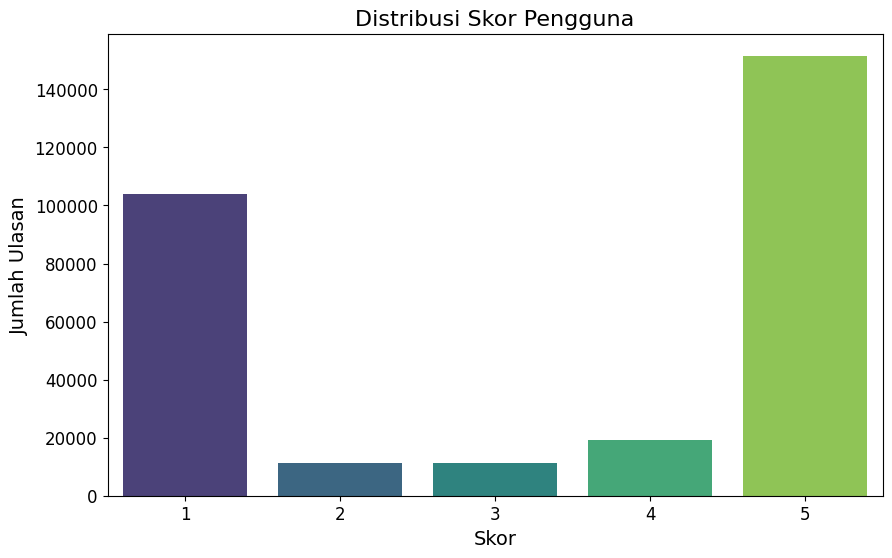

In [11]:
# Menghitung distribusi skor
score_distribution = df['score'].value_counts().sort_index()

# Plot distribusi skor
plt.figure(figsize=(10, 6))
sns.barplot(x=score_distribution.index, y=score_distribution.values, palette="viridis")
plt.title('Distribusi Skor Pengguna', fontsize=16)
plt.xlabel('Skor', fontsize=14)
plt.ylabel('Jumlah Ulasan', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

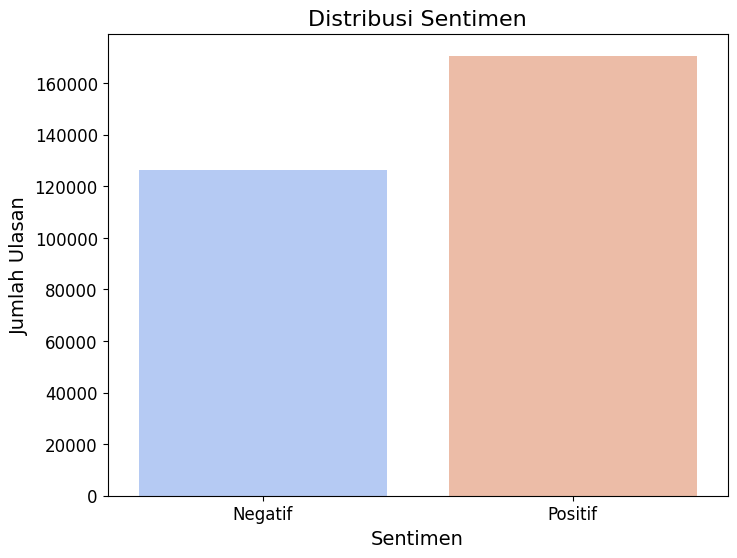

In [12]:
# Menghitung distribusi sentimen
sentiment_distribution = df['sentiment'].value_counts()

# Plot distribusi sentimen
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_distribution.index, y=sentiment_distribution.values, palette="coolwarm")
plt.title('Distribusi Sentimen', fontsize=16)
plt.xlabel('Sentimen', fontsize=14)
plt.ylabel('Jumlah Ulasan', fontsize=14)
plt.xticks(ticks=[0, 1], labels=['Negatif', 'Positif'], fontsize=12)
plt.yticks(fontsize=12)
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


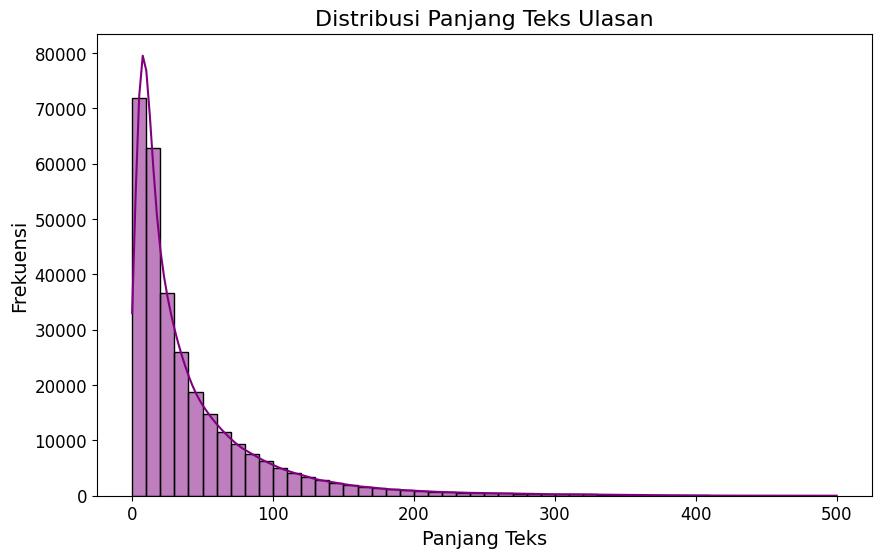

In [13]:
# Menghitung panjang teks ulasan
df['text_length'] = df['cleaned_content'].apply(len)

# Plot distribusi panjang teks
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=50, kde=True, color='purple')
plt.title('Distribusi Panjang Teks Ulasan', fontsize=16)
plt.xlabel('Panjang Teks', fontsize=14)
plt.ylabel('Frekuensi', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

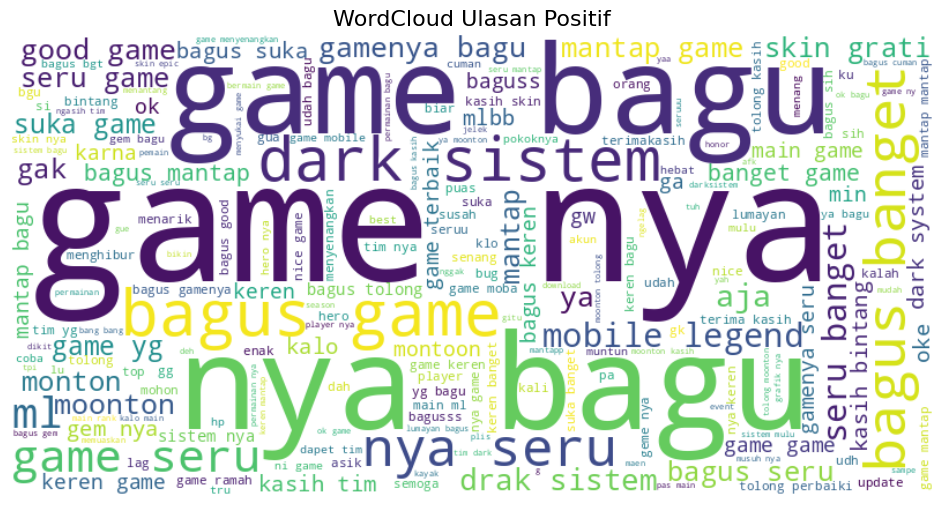

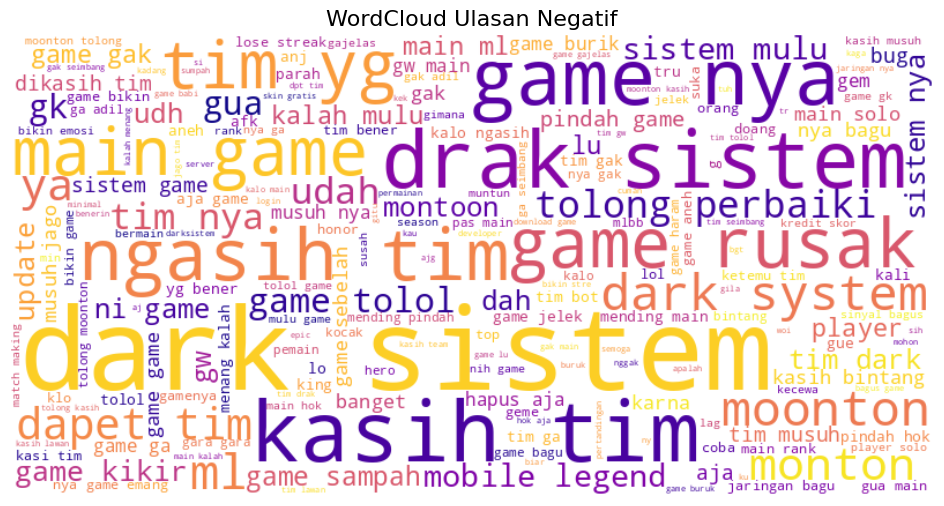

In [14]:
# WordCloud untuk ulasan positif
wordcloud_positive = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(' '.join(positive_reviews))
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud Ulasan Positif', fontsize=16)
plt.show()

# WordCloud untuk ulasan negatif
wordcloud_negative = WordCloud(width=800, height=400, background_color='white', colormap='plasma').generate(' '.join(negative_reviews))
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud Ulasan Negatif', fontsize=16)
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


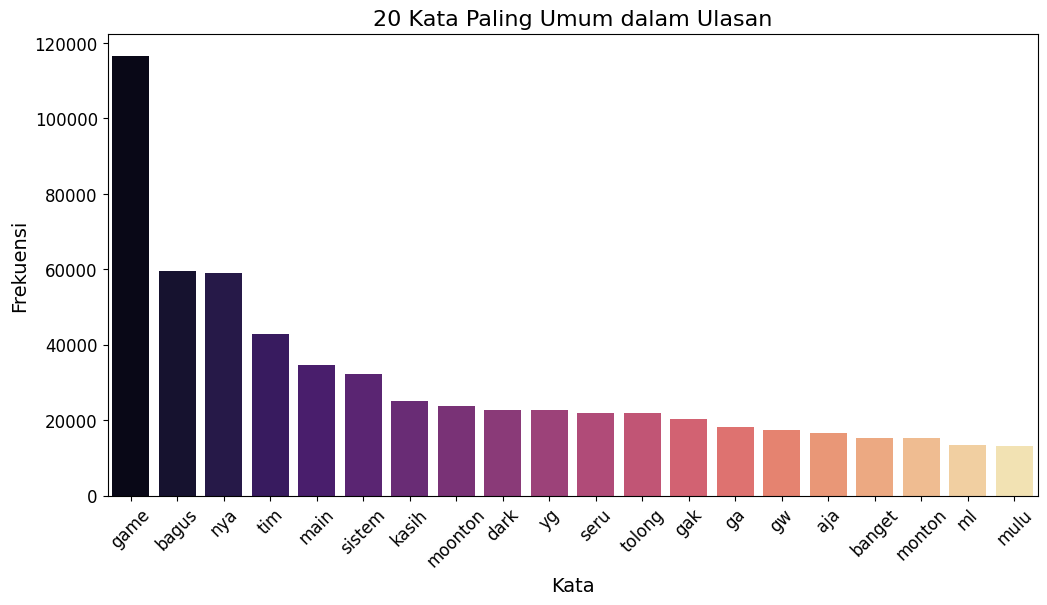

In [15]:
# Menggabungkan semua teks ulasan
all_words = ' '.join(df['cleaned_content'])

# Tokenisasi dan menghitung frekuensi kata
words = word_tokenize(all_words)
word_freq = Counter(words)

# 20 kata paling umum
common_words = word_freq.most_common(20)

# Plot frekuensi kata
plt.figure(figsize=(12, 6))
sns.barplot(x=[word[0] for word in common_words], y=[word[1] for word in common_words], palette="magma")
plt.title('20 Kata Paling Umum dalam Ulasan', fontsize=16)
plt.xlabel('Kata', fontsize=14)
plt.ylabel('Frekuensi', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# **PEMODELAN** 

In [16]:
#df = pd.read_csv('/kaggle/input/processed-dataset/processed_reviews.csv')

In [17]:
# Memisahkan fitur (teks) dan target (sentimen)
X = df['cleaned_content']
y = df['sentiment']

# Membagi data menjadi train dan test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## **LSTM**

In [18]:
# Tokenisasi teks
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

# Ubah teks menjadi sequence
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding sequence
X_train_pad = pad_sequences(X_train_seq, maxlen=200)
X_test_pad = pad_sequences(X_test_seq, maxlen=200)

In [19]:
# Membangun model
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=5000, output_dim=128, input_length=200))
model_lstm.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model_lstm.add(Dense(1, activation='sigmoid'))

# Compile model
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_lstm.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Melatih model
history_lstm = model_lstm.fit(X_train_pad, y_train, epochs=3, batch_size=64, validation_split=0.2)

Epoch 1/3
2970/2970 ━━━━━━━━━━━━━━━━━━━━ 817s 273ms/step - accuracy: 0.8462 - loss: 0.3677 - val_accuracy: 0.8775 - val_loss: 0.3143
Epoch 2/3
2970/2970 ━━━━━━━━━━━━━━━━━━━━ 813s 274ms/step - accuracy: 0.8803 - loss: 0.3056 - val_accuracy: 0.8779 - val_loss: 0.3115
Epoch 3/3
2970/2970 ━━━━━━━━━━━━━━━━━━━━ 822s 277ms/step - accuracy: 0.8863 - loss: 0.2946 - val_accuracy: 0.8779 - val_loss: 0.3137


1857/1857 ━━━━━━━━━━━━━━━━━━━━ 137s 74ms/step
              precision    recall  f1-score   support

           0       0.84      0.87      0.86     25198
           1       0.90      0.88      0.89     34202

    accuracy                           0.88     59400
   macro avg       0.87      0.87      0.87     59400
weighted avg       0.88      0.88      0.88     59400



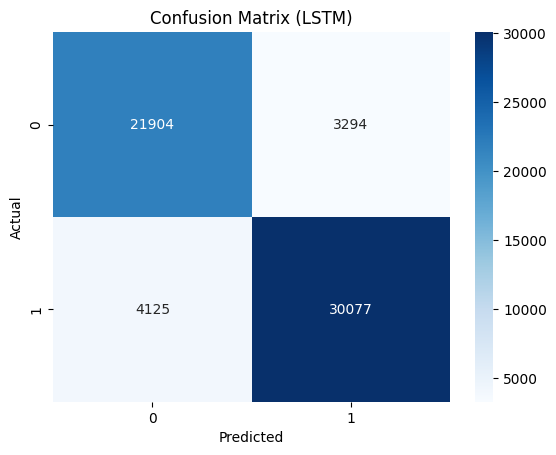

In [21]:
# Prediksi
y_pred_lstm = (model_lstm.predict(X_test_pad) > 0.5).astype(int)

# Laporan klasifikasi
print(classification_report(y_test, y_pred_lstm))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_lstm)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (LSTM)')
plt.show()

## **BiLSTM**

In [22]:
# Tokenisasi teks
num_words = 5000  # Jumlah maksimal kata dalam tokenisasi
max_len = 200  # Panjang maksimal urutan teks

In [23]:
# Model BiLSTM
model_bilstm = Sequential()
model_bilstm.add(Embedding(input_dim=num_words, output_dim=128, input_length=max_len))
model_bilstm.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))
model_bilstm.add(Dense(1, activation='sigmoid'))

# Compile model
model_bilstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_bilstm.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Melatih model
history_bilstm = model_bilstm.fit(X_train_pad, y_train, epochs=3, batch_size=64, validation_split=0.2)

Epoch 1/3
2970/2970 ━━━━━━━━━━━━━━━━━━━━ 1343s 451ms/step - accuracy: 0.8417 - loss: 0.3754 - val_accuracy: 0.8791 - val_loss: 0.3108
Epoch 2/3
2970/2970 ━━━━━━━━━━━━━━━━━━━━ 1338s 451ms/step - accuracy: 0.8795 - loss: 0.3086 - val_accuracy: 0.8773 - val_loss: 0.3123
Epoch 3/3
2970/2970 ━━━━━━━━━━━━━━━━━━━━ 1346s 453ms/step - accuracy: 0.8864 - loss: 0.2939 - val_accuracy: 0.8792 - val_loss: 0.3118


1857/1857 ━━━━━━━━━━━━━━━━━━━━ 161s 87ms/step

Evaluasi BiLSTM:
              precision    recall  f1-score   support

           0       0.85      0.86      0.85     25198
           1       0.90      0.89      0.89     34202

    accuracy                           0.88     59400
   macro avg       0.87      0.87      0.87     59400
weighted avg       0.88      0.88      0.88     59400



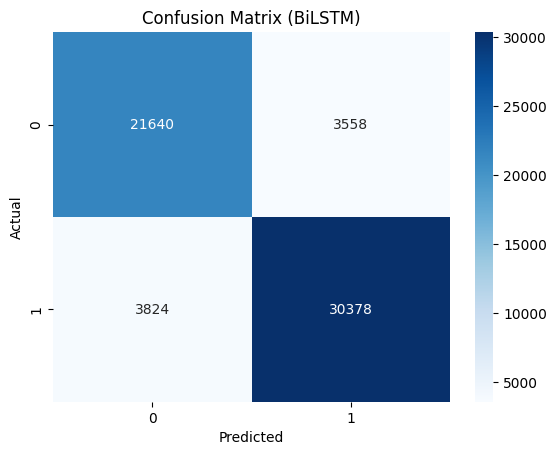

In [30]:
# Evaluasi model BiLSTM
y_pred_bilstm = (model_bilstm.predict(X_test_pad) > 0.5).astype('int32')
print("\nEvaluasi BiLSTM:")

# Laporan klasifikasi
print(classification_report(y_test, y_pred_bilstm))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_bilstm)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (BiLSTM)')
plt.show()

## **GRU**

In [33]:
# Model GRU
model_gru = Sequential()
model_gru.add(Embedding(input_dim=num_words, output_dim=128, input_length=max_len))
model_gru.add(GRU(128, dropout=0.2, recurrent_dropout=0.2))
model_gru.add(Dense(1, activation='sigmoid'))

# Compile model
model_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_gru.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Melatih model
history_gru = model_gru.fit(X_train_pad, y_train, epochs=3, batch_size=64, validation_split=0.2)

Epoch 1/3
2970/2970 ━━━━━━━━━━━━━━━━━━━━ 1053s 354ms/step - accuracy: 0.8048 - loss: 295844224.0000 - val_accuracy: 0.8196 - val_loss: 0.4072
Epoch 2/3
2970/2970 ━━━━━━━━━━━━━━━━━━━━ 1062s 358ms/step - accuracy: 0.8376 - loss: 0.6653 - val_accuracy: 0.8165 - val_loss: 0.4107
Epoch 3/3
2970/2970 ━━━━━━━━━━━━━━━━━━━━ 1069s 360ms/step - accuracy: 0.8421 - loss: 1.2939 - val_accuracy: 0.8191 - val_loss: 0.4095


1857/1857 ━━━━━━━━━━━━━━━━━━━━ 159s 85ms/step

Evaluasi GRU:
              precision    recall  f1-score   support

           0       0.79      0.78      0.78     25198
           1       0.84      0.84      0.84     34202

    accuracy                           0.82     59400
   macro avg       0.81      0.81      0.81     59400
weighted avg       0.82      0.82      0.82     59400



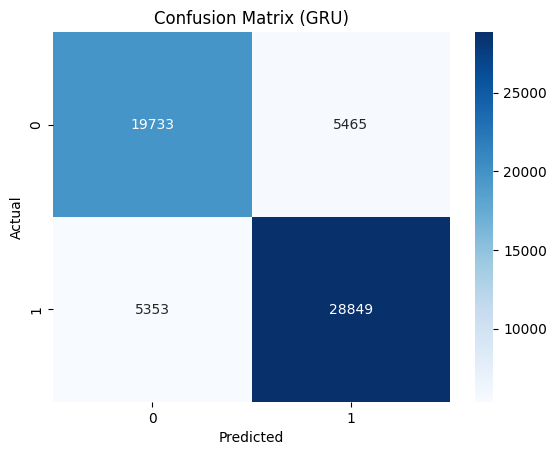

In [29]:
# Evaluasi model GRU
y_pred_gru = (model_gru.predict(X_test_pad) > 0.5).astype('int32')
print("\nEvaluasi GRU:")

# Laporan klasifikasi
print(classification_report(y_test, y_pred_gru))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_gru)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (GRU)')
plt.show()

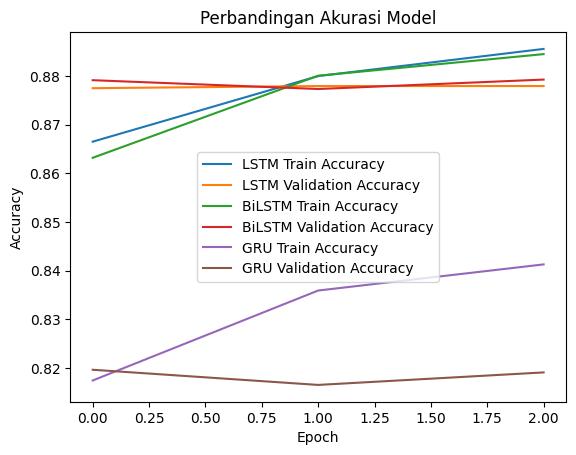

In [31]:
# Plot untuk LSTM
plt.plot(history_lstm.history['accuracy'], label='LSTM Train Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='LSTM Validation Accuracy')
plt.plot(history_bilstm.history['accuracy'], label='BiLSTM Train Accuracy')
plt.plot(history_bilstm.history['val_accuracy'], label='BiLSTM Validation Accuracy')
plt.plot(history_gru.history['accuracy'], label='GRU Train Accuracy')
plt.plot(history_gru.history['val_accuracy'], label='GRU Validation Accuracy')
plt.title('Perbandingan Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [32]:
# Simpan model LSTM
model_lstm.save('sentiment_lstm_model.h5')

# Simpan model BiLSTM
model_bilstm.save('sentiment_bilstm_model.h5')

# Simpan model GRU
model_gru.save('sentiment_gru_model.h5')